In [ ]:
from google.colab import drive
import os
import sys
import shutil
import subprocess

drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_DIR}/code"
DATA_PATH = f"{PROJECT_DIR}/data"
TEST_PATH = f"{PROJECT_DIR}/test"
MODEL_PATH = f"{PROJECT_DIR}/models"

ORIGINAL_PROMPT = "A bonsai tree in a pot"
EDIT_PROMPT = "Make the tree's branches thicker and more robust, while maintaining the overall shape and style of the original bonsai tree."
DIFFUSION_PROMPT = f"""
{EDIT_PROMPT}

Do not change other parts of the picture, follow the drawing style of the original picture.
"""

INPUT_SVG_PATH = "/content/drive/MyDrive/SVGEditor/test/bonsai/bonsai_optim_point.svg"
TARGET_NAME = "bonsai"
OUTPUT_PATH = "/content/drive/MyDrive/SVGEditor/test/testCase"

In [ ]:
# 1. Clean existing code directory and clone fresh repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_DIR)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Code repository {'successfully' if result.returncode == 0 else 'failed'} to {CODE_PATH}{f', {result.stderr}' if result.returncode != 0 else ''}")

# 2. Display latest commit information
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%H|%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    hash_code, commit_time, commit_msg = commit_info.stdout.strip().split('|', 2)
    print(f"Latest commit:\n   Hash: {hash_code[:8]}\n   Time: {commit_time}\n   Message: {commit_msg}")

# 3. Add code path to Python sys.path so we can import our modules
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)
    print(f"✅ Added {CODE_PATH} to Python path")

# 4. Clear custom modules from cache
modules_to_clear = [

]

for base in modules_to_clear:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

print("✅ Modules reloaded!")

In [ ]:
%pip install diffusers accelerate safetensors transformers huggingface_hub

In [ ]:
# 下载所有模型的脚本
from huggingface_hub import snapshot_download
import os

MODEL_BASE_PATH = "/content/drive/MyDrive/SVGEditor/models"

models_config = {
    # 原有模型
    "instruct-pix2pix": "timbrooks/instruct-pix2pix",
    "stable-diffusion-v1-5": "runwayml/stable-diffusion-v1-5",
    "stable-diffusion-inpainting": "runwayml/stable-diffusion-inpainting",
    "controlnet-canny": "lllyasviel/sd-controlnet-canny",
    
    # 新增：SDXL 相关模型
    "stable-diffusion-xl-base": "stabilityai/stable-diffusion-xl-base-1.0",
    "controlnet-canny-sdxl": "diffusers/controlnet-canny-sdxl-1.0",
    
    # 新增：IP-Adapter 模型（风格控制）
    "ip-adapter": "h94/IP-Adapter"
}

def download_all_models():
    for model_name, model_id in models_config.items():
        model_path = f"{MODEL_BASE_PATH}/{model_name}"
        print(f"Downloading {model_name}...")
        snapshot_download(
            repo_id=model_id,
            local_dir=model_path
        )
        print(f"✅ {model_name} downloaded successfully")

# 执行下载
download_all_models()

In [ ]:
# # 重新安装PyTorch以解决METH_CLASS错误
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # 重新安装segment-anything
# !pip uninstall segment-anything -y
# !pip install segment-anything

# print("✅ PyTorch and segment-anything reinstalled")

In [ ]:
# ========================================
# 模型下载Cell - 只运行一次，下载后可以注释掉
# ========================================

from huggingface_hub import snapshot_download
import os

MODEL_PATH = f"{PROJECT_DIR}/models"

def download_models():
    """下载并缓存instruct-pix2pix模型到Google Drive"""
    models_config = {
        "instruct-pix2pix": "timbrooks/instruct-pix2pix"
    }

    print("🚀 Starting model download process...")
    print(f"📁 Model cache directory: {MODEL_PATH}")

    # 创建模型目录
    os.makedirs(MODEL_PATH, exist_ok=True)

    for model_name, model_id in models_config.items():
        model_dir = f"{MODEL_PATH}/{model_name}"

        if not os.path.exists(model_dir):
            print(f" Downloading {model_name}...")
            try:
                snapshot_download(
                    repo_id=model_id,
                    local_dir=model_dir
                )
                print(f"✅ {model_name} downloaded successfully")
            except Exception as e:
                print(f"❌ Failed to download {model_name}: {e}")
        else:
            print(f"✅ {model_name} already cached")

    print(" Model ready!")

# 执行下载
download_models()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

✅ Image loaded: (512, 512)


  0%|          | 0/10 [00:00<?, ?it/s]

 Result image size: (512, 512)


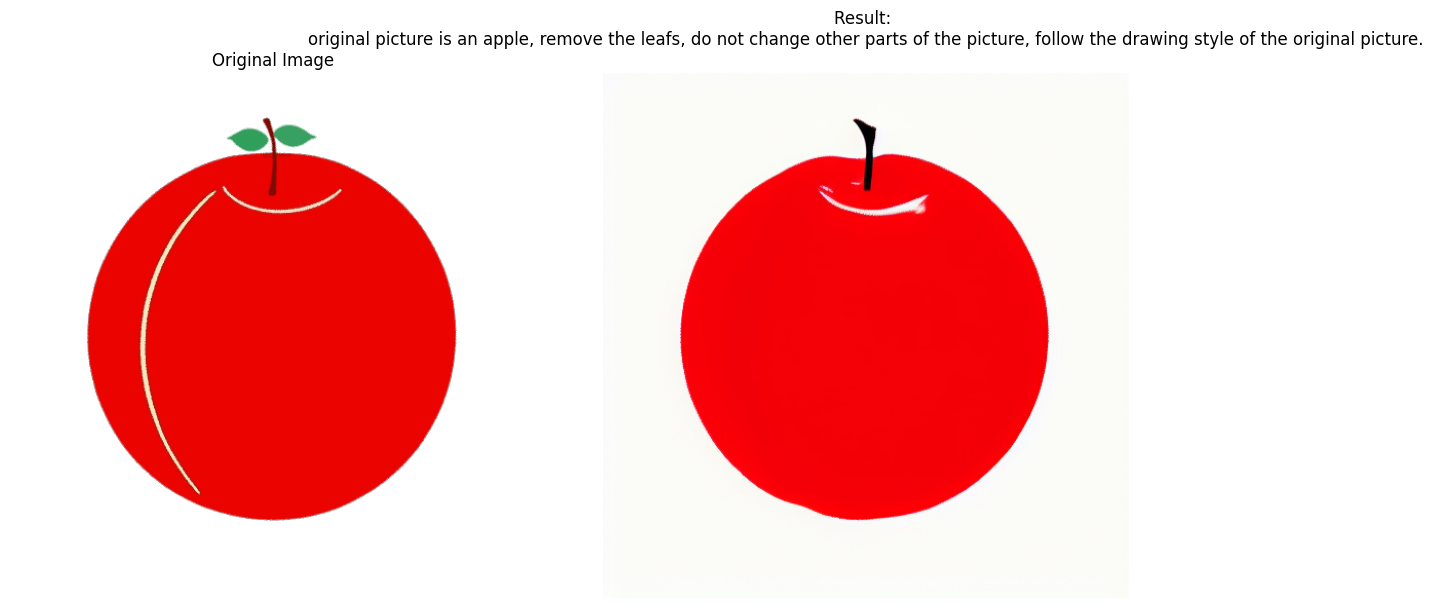

✅ Result image saved successfully as: image_point_optim_500_edited.png


In [39]:
# ========================================
# 从本地缓存加载模型并运行demo
# ========================================
import PIL
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import matplotlib.pyplot as plt
import os

# 从本地缓存加载模型
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    f"{MODEL_PATH}/instruct-pix2pix",
    torch_dtype=torch.float16,
    safety_checker=None
)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

# 检查文件是否存在
if os.path.exists(f"{DATA_PATH}/image_point_optim_500.png"):
    image = PIL.Image.open(f"{DATA_PATH}/image_point_optim_500.png")
    image = image.convert("RGB")
    print(f"✅ Image loaded: {image.size}")

# 运行demo
prompt = """
original picture is an apple, remove the leafs, do not change other parts of the picture, follow the drawing style of the original picture.
"""

images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=2).images
print(f" Result image size: {images[0].size}")

# 显示原图和结果图对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(images[0])
axes[1].set_title(f"Result: {prompt}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 保存图片到Google Drive（覆盖已存在的文件）
images[0].save(f"{DATA_PATH}/image_point_optim_500_edited.png")
print(f"✅ Result image saved successfully as: image_point_optim_500_edited.png")

In [45]:
# ========================================
# SAM (Segment Anything Model) 处理
# ========================================

# 导入SAM处理模块
from sam_processor import process_image_with_sam, save_masks_to_directory, get_default_sam_config

# 配置SAM参数（参考原项目的配置）
sam_config = get_default_sam_config(PROJECT_DIR)
sam_config.update({
    "points_per_side": 48,  # 参考原项目的fine配置
    "pred_iou_thresh": 0.87,
    "stability_score_thresh": 0.95,
    "min_mask_region_area": 30,
})

# 输入图片路径（使用上一个cell处理后的结果图片）
input_image_path = f"{DATA_PATH}/image_point_optim_500_edited.png"
sam_model_path = f"{MODEL_PATH}/sam/sam_vit_h_4b8939.pth"

print(f"🎭 Starting SAM processing...")
print(f"📂 Input image: {input_image_path}")
print(f"🤖 SAM model: {sam_model_path}")

# 检查输入文件是否存在
if not os.path.exists(input_image_path):
    print(f"❌ Input image not found: {input_image_path}")
else:
    # 处理图片生成masks
    try:
        masks, original_image = process_image_with_sam(
            image_path=input_image_path,
            sam_config=sam_config,
            model_path=sam_model_path
        )

        print(f"✅ SAM processing completed!")
        print(f"📊 Generated {len(masks)} masks")

        # 保存masks到TEST_PATH目录（幂等操作，会覆盖现有文件）
        save_masks_to_directory(
            masks=masks,
            image=original_image,
            output_dir=TEST_PATH,
            base_filename="sam_mask"
        )

        print(f"💾 Masks saved to: {TEST_PATH}")

        # 显示前5个最大的masks的统计信息
        if masks:
            sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)
            print(f"\n📈 Top 5 largest masks:")
            for i, mask_data in enumerate(sorted_masks[:5]):
                print(f"  {i+1}. Area: {mask_data['area']:.0f}, IoU: {mask_data['predicted_iou']:.3f}, Stability: {mask_data['stability_score']:.3f}")

    except Exception as e:
        print(f"❌ SAM processing failed: {str(e)}")
        print("Please check that the SAM model file exists and the input image is valid.")


🎭 Starting SAM processing...
📂 Input image: /content/drive/MyDrive/SVGEditor/data/image_point_optim_500_edited.png
🤖 SAM model: /content/drive/MyDrive/SVGEditor/models/sam/sam_vit_h_4b8939.pth
🔄 Loading SAM model from: /content/drive/MyDrive/SVGEditor/models/sam/sam_vit_h_4b8939.pth
✅ SAM model loaded successfully
🖼️ Processing image: /content/drive/MyDrive/SVGEditor/data/image_point_optim_500_edited.png
🎭 Generating masks...
✅ Generated 6 masks
✅ SAM processing completed!
📊 Generated 6 masks
💾 Saving 6 masks to: /content/drive/MyDrive/SVGEditor/test
✅ Saved 6 individual masks + 1 combined view
📁 Files saved to: /content/drive/MyDrive/SVGEditor/test
💾 Masks saved to: /content/drive/MyDrive/SVGEditor/test

📈 Top 5 largest masks:
  1. Area: 159586, IoU: 1.019, Stability: 0.981
  2. Area: 100385, IoU: 1.023, Stability: 0.992
  3. Area: 775, IoU: 0.967, Stability: 0.966
  4. Area: 590, IoU: 0.979, Stability: 0.985
  5. Area: 75, IoU: 0.912, Stability: 0.962


In [5]:
# ========================================
# SAM Masks 矢量化处理
# ========================================

import cv2
import numpy as np
from skimage import measure
from sklearn.cluster import KMeans
from svglib.svg import SVG, SVGPath
from svglib.geom import Bbox
import os

def get_dominant_color(pixels, n_colors=5):
    """提取主要颜色"""
    pixels = pixels.reshape(-1, 3)
    n_colors = min(n_colors, len(pixels))
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)
    dominant_color = tuple(colors[np.argmax(counts)])
    return dominant_color

def vectorize_masks_to_svg(image: np.ndarray, masks: list) -> SVG:
    """将masks转换为SVG对象"""
    # 按面积排序masks（从大到小）
    sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)

    svg_path_groups = []

    for i, mask in enumerate(sorted_masks):
        binary_mask = mask['segmentation'].astype(np.uint8)
        contours = measure.find_contours(binary_mask)

        # 减去更小的masks（避免重叠）
        for smaller_mask in sorted_masks[i+1:]:
            binary_mask = np.logical_and(binary_mask, np.logical_not(smaller_mask['segmentation']))

        # 转换回uint8
        binary_mask = binary_mask.astype(np.uint8)
        pixels = image[binary_mask.astype(bool)]

        if len(pixels) > 0:  # 确保有像素数据
            color = get_dominant_color(pixels)
            color_hex = '#{:02x}{:02x}{:02x}'.format(*color)

            for contour in contours:
                # 简化轮廓
                epsilon = 0.0008 * cv2.arcLength(contour.astype(np.float32), True)
                approx = cv2.approxPolyDP(contour.astype(np.float32), epsilon, True)

                # 生成SVG path数据
                path_data = []
                for j in range(len(approx)):
                    y, x = approx[j][0]
                    if j == 0:
                        path_data.append(f'M {x:.2f} {y:.2f}')
                    else:
                        path_data.append(f'L {x:.2f} {y:.2f}')
                path_data.append('Z')  # 闭合路径

                # 创建SVG path
                svg_path_group = SVGPath.from_str(
                    ' '.join(path_data),
                    fill=True,
                    color=color_hex,
                    add_closing=True,
                )
                svg_path_groups.append(svg_path_group)

    # 创建SVG对象
    viewbox = Bbox(0, 0, image.shape[1], image.shape[0])
    svg = SVG(svg_path_groups, viewbox=viewbox)
    return svg

# 输入图片路径（转换为Google Drive路径）
input_image_path = "/content/drive/MyDrive/SVGEditor/test/apple/apple_target.png"
output_svg_path = "/content/drive/MyDrive/SVGEditor/test/testCase1/vectorized_output.svg"

print(f"🎨 Starting vectorization process...")
print(f"📂 Input image: {input_image_path}")
print(f"�� Output SVG: {output_svg_path}")

# 检查输入文件是否存在
if not os.path.exists(input_image_path):
    print(f"❌ Input image not found: {input_image_path}")
else:
    try:
        # 加载图片
        image = cv2.imread(input_image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(f"✅ Image loaded: {image_rgb.shape}")

        # 使用SAM处理生成masks（假设masks已经存在，或者重新生成）
        # 这里可以复用之前的SAM处理逻辑，或者加载已保存的masks
        print("�� Generating masks with SAM...")

        # 临时：如果masks不存在，重新生成
        # 实际使用时，可以从之前的SAM处理结果中获取masks
        from sam_processor import process_image_with_sam, get_default_sam_config

        sam_config = get_default_sam_config(PROJECT_DIR)
        sam_config.update({
            "points_per_side": 48,
            "pred_iou_thresh": 0.87,
            "stability_score_thresh": 0.95,
            "min_mask_region_area": 30,
        })

        sam_model_path = f"{MODEL_PATH}/sam/sam_vit_h_4b8939.pth"
        masks, _ = process_image_with_sam(
            image_path=input_image_path,
            sam_config=sam_config,
            model_path=sam_model_path
        )

        print(f"✅ Generated {len(masks)} masks")

        # 矢量化处理
        print("🔧 Converting masks to SVG...")
        svg = vectorize_masks_to_svg(image_rgb, masks)

        # 后处理：优化SVG
        print("✨ Optimizing SVG...")
        svg.line_to_bezier().drop_z().filter_duplicates().filter_consecutives().filter_empty()

        # 创建输出目录
        os.makedirs(os.path.dirname(output_svg_path), exist_ok=True)

        # 保存SVG
        svg.save_svg(output_svg_path, coordinate_precision=3)

        print(f"✅ SVG saved successfully to: {output_svg_path}")
        print(f"📊 SVG contains {len(svg.svg_path_groups)} path groups")

        # 显示SVG信息
        print(f"\n📈 SVG Statistics:")
        print(f"  - Viewbox: {svg.viewbox}")
        print(f"  - Path groups: {len(svg.svg_path_groups)}")
        print(f"  - File size: {os.path.getsize(output_svg_path)} bytes")

    except Exception as e:
        print(f"❌ Vectorization failed: {str(e)}")
        import traceback
        traceback.print_exc()

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



🎨 Starting vectorization process...
📂 Input image: /content/drive/MyDrive/SVGEditor/test/apple/apple_target.png
�� Output SVG: /content/drive/MyDrive/SVGEditor/test/testCase1/vectorized_output.svg
✅ Image loaded: (512, 512, 3)
�� Generating masks with SAM...
🔄 Loading SAM model from: /content/drive/MyDrive/SVGEditor/models/sam/sam_vit_h_4b8939.pth
✅ SAM model loaded successfully
🖼️ Processing image: /content/drive/MyDrive/SVGEditor/test/apple/apple_target.png
🎭 Generating masks...
✅ Generated 11 masks
✅ Generated 11 masks
🔧 Converting masks to SVG...
✨ Optimizing SVG...
✅ SVG saved successfully to: /content/drive/MyDrive/SVGEditor/test/testCase1/vectorized_output.svg
📊 SVG contains 13 path groups

📈 SVG Statistics:
  - Viewbox: Bbox(0 0 512 512)
  - Path groups: 13
  - File size: 37125 bytes


In [ ]:
# ========================================
# Diffusion 编辑处理
# ========================================

import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import matplotlib.pyplot as plt
from PIL import Image
import os

# 从保存的 PNG 文件加载图像
pil_image = Image.open(os.path.join(OUTPUT_PATH, f"{TARGET_NAME}_original.png"))

# 从本地缓存加载模型
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    f"{MODEL_PATH}/instruct-pix2pix",
    torch_dtype=torch.float16,
    safety_checker=None
)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

# 使用拼接后的 prompt 进行 diffusion 编辑
images = pipe(DIFFUSION_PROMPT, image=pil_image, num_inference_steps=10, image_guidance_scale=5).images
diffusion_edited_image = images[0]

# 显示原图和编辑后的图片对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(pil_image)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(diffusion_edited_image)
axes[1].set_title(f"Diffusion Edited")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 保存编辑后的图片
edited_filename = f"{TARGET_NAME}_diffusion_edited.png"
saved_edited_path = save_pil_image(diffusion_edited_image, OUTPUT_PATH, edited_filename)

print(f"✅ Diffusion edited image saved: {saved_edited_path}")

In [ ]:
# ========================================
# Diffusion 编辑后的图像矢量化处理
# ========================================

import cv2
import numpy as np
from skimage import measure
from sklearn.cluster import KMeans
from svglib.svg import SVG, SVGPath
from svglib.geom import Bbox
import os
from PIL import Image

# 从保存的编辑后PNG文件加载图像
diffusion_edited_image = Image.open(os.path.join(OUTPUT_PATH, f"{TARGET_NAME}_diffusion_edited.png"))

def get_dominant_color(pixels, n_colors=5):
    """提取主要颜色"""
    pixels = pixels.reshape(-1, 3)
    n_colors = min(n_colors, len(pixels))
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)
    dominant_color = tuple(colors[np.argmax(counts)])
    return dominant_color

def vectorize_masks_to_svg(image: np.ndarray, masks: list) -> SVG:
    """将masks转换为SVG对象"""
    sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)
    svg_path_groups = []

    for i, mask in enumerate(sorted_masks):
        binary_mask = mask['segmentation'].astype(np.uint8)
        contours = measure.find_contours(binary_mask)

        # 减去更小的masks（避免重叠）
        for smaller_mask in sorted_masks[i+1:]:
            binary_mask = np.logical_and(binary_mask, np.logical_not(smaller_mask['segmentation']))

        binary_mask = binary_mask.astype(np.uint8)
        pixels = image[binary_mask.astype(bool)]

        if len(pixels) > 0:
            color = get_dominant_color(pixels)
            color_hex = '#{:02x}{:02x}{:02x}'.format(*color)

            for contour in contours:
                epsilon = 0.0008 * cv2.arcLength(contour.astype(np.float32), True)
                approx = cv2.approxPolyDP(contour.astype(np.float32), epsilon, True)

                path_data = []
                for j in range(len(approx)):
                    y, x = approx[j][0]
                    if j == 0:
                        path_data.append(f'M {x:.2f} {y:.2f}')
                    else:
                        path_data.append(f'L {x:.2f} {y:.2f}')
                path_data.append('Z')

                svg_path_group = SVGPath.from_str(
                    ' '.join(path_data),
                    fill=True,
                    color=color_hex,
                    add_closing=True,
                )
                svg_path_groups.append(svg_path_group)

    viewbox = Bbox(0, 0, image.shape[1], image.shape[0])
    svg = SVG(svg_path_groups, viewbox=viewbox)
    return svg

# 将PIL图像转换为numpy数组
image_rgb = np.array(diffusion_edited_image)

# 使用SAM处理生成masks
from sam_processor import process_image_with_sam, get_default_sam_config

sam_config = get_default_sam_config(PROJECT_DIR)
sam_config.update({
    "points_per_side": 48,
    "pred_iou_thresh": 0.87,
    "stability_score_thresh": 0.95,
    "min_mask_region_area": 30,
})

sam_model_path = f"{MODEL_PATH}/sam/sam_vit_h_4b8939.pth"
masks, _ = process_image_with_sam(
    image_path=None,  # 直接使用内存中的图像
    sam_config=sam_config,
    model_path=sam_model_path,
    image_array=image_rgb  # 传入numpy数组
)

# 保存masks到文件
for i, mask in enumerate(masks):
    mask_filename = f"{TARGET_NAME}_mask_{i:04d}.png"
    mask_path = os.path.join(OUTPUT_PATH, mask_filename)
    cv2.imwrite(mask_path, mask['segmentation'].astype(np.uint8) * 255)

# 矢量化处理
svg = vectorize_masks_to_svg(image_rgb, masks)

# 后处理：优化SVG
svg.line_to_bezier().drop_z().filter_duplicates().filter_consecutives().filter_empty()

# 保存SVG
output_svg_path = os.path.join(OUTPUT_PATH, f"{TARGET_NAME}_output.svg")
svg.save_svg(output_svg_path, coordinate_precision=3)

print(f"✅ Generated {len(masks)} masks")
print(f"✅ Masks saved to: {OUTPUT_PATH}")
print(f"✅ SVG saved to: {output_svg_path}")
print(f"📊 SVG contains {len(svg.svg_path_groups)} path groups")

In [5]:
# ========================================
# Stable Diffusion Img2Img 编辑处理 - 内存优化版本
# ========================================

import torch
from diffusers import StableDiffusionImg2ImgPipeline
import matplotlib.pyplot as plt
from PIL import Image
import os

# 清理 GPU 内存
torch.cuda.empty_cache()

# 设置内存优化
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# 从保存的 PNG 文件加载图像
pil_image = Image.open(os.path.join(OUTPUT_PATH, f"{TARGET_NAME}_original.png"))

# 从本地缓存加载模型（移除 dtype 参数）
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    f"{MODEL_PATH}/stable-diffusion-v1-5",
    torch_dtype=torch.float16,  # 使用 torch_dtype 而不是 dtype
    low_cpu_mem_usage=True
).to("cuda")

# 启用内存优化
pipe.enable_attention_slicing()
pipe.enable_vae_slicing()

# 使用更小的图像尺寸
pil_image_small = pil_image.resize((128, 128))

# 使用 Img2Img 进行编辑
result = pipe(
    prompt=DIFFUSION_PROMPT,
    image=pil_image_small,
    strength=0.35,  # 低 strength 保持原图结构
    guidance_scale=7.5,
    num_inference_steps=10  # 减少推理步数
)
diffusion_edited_image = result.images[0]

# 显示原图和编辑后的图片对比
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(pil_image_small)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(diffusion_edited_image)
axes[1].set_title("Img2Img Edited")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 保存编辑后的图片
edited_filename = f"{TARGET_NAME}_img2img_edited.png"
saved_edited_path = os.path.join(OUTPUT_PATH, edited_filename)
diffusion_edited_image.save(saved_edited_path)

print(f"✅ Img2Img edited image saved: {saved_edited_path}")

# 清理内存
del pipe
torch.cuda.empty_cache()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1.05 GiB is free. Process 23217 has 38.50 GiB memory in use. Of the allocated memory 37.95 GiB is allocated by PyTorch, and 54.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

 Loading ControlNet model from Hugging Face...
🔄 Loading base model from local cache...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

 Generating Canny edges...
 Editing with ControlNet...


  0%|          | 0/500 [00:00<?, ?it/s]

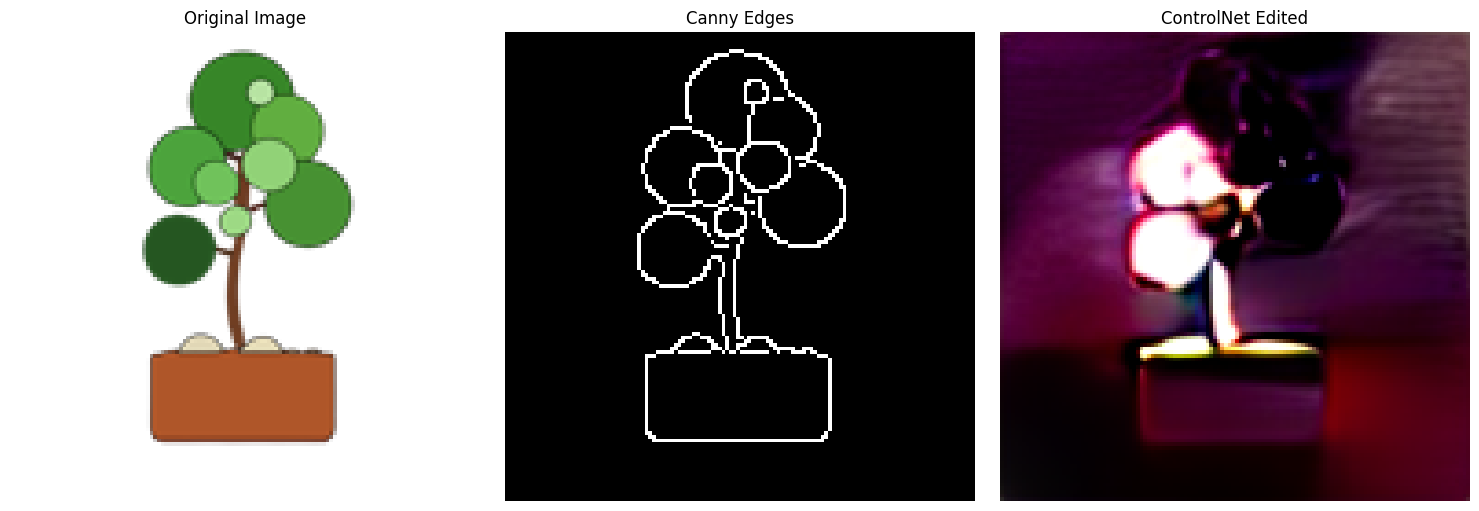

✅ ControlNet edited image saved: /content/drive/MyDrive/SVGEditor/test/testCase/bonsai_controlnet_edited.png


6804

In [23]:
# ========================================
# 使用本地 SD 1.5 模型
# ========================================

import torch
import gc
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# 强制清理所有内存
torch.cuda.empty_cache()
gc.collect()

# 设置内存优化
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# 从保存的 PNG 文件加载图像
pil_image = Image.open(os.path.join(OUTPUT_PATH, f"{TARGET_NAME}_original.png"))

# 使用本地 SD 1.5 模型
print(" Loading ControlNet model from Hugging Face...")
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny"
)

print("🔄 Loading base model from local cache...")
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    f"{MODEL_PATH}/stable-diffusion-v1-5",  # 使用本地模型
    controlnet=controlnet,
    safety_checker=None,
    requires_safety_checker=False
).to("cuda")

# 启用内存优化
pipe.enable_attention_slicing()
pipe.enable_vae_slicing()

# 使用更小的图像尺寸
pil_image_small = pil_image.resize((128, 128))

# 生成 Canny 边缘图
print(" Generating Canny edges...")
image_cv = cv2.cvtColor(np.array(pil_image_small), cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 200)
canny_image = Image.fromarray(edges)

# 显示边缘检测结果
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(pil_image_small)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(canny_image, cmap='gray')
axes[1].set_title("Canny Edges")
axes[1].axis('off')

# 使用 ControlNet 进行编辑，优化参数
print(" Editing with ControlNet...")
result = pipe(
    prompt="make the tree's branches thicker and more robust; keep flat colors; anime/cartoon style; no texture; maintain original color palette; preserve white background",
    image=canny_image,
    controlnet_conditioning_scale=6.9,  # 降低控制强度
    guidance_scale=30.0,  # 降低引导强度
    num_inference_steps=500  # 减少推理步数
)
diffusion_edited_image = result.images[0]

# 显示编辑结果
axes[2].imshow(diffusion_edited_image)
axes[2].set_title("ControlNet Edited")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# 保存编辑后的图片
edited_filename = f"{TARGET_NAME}_controlnet_edited.png"
saved_edited_path = os.path.join(OUTPUT_PATH, edited_filename)
diffusion_edited_image.save(saved_edited_path)

print(f"✅ ControlNet edited image saved: {saved_edited_path}")

# 清理内存
del pipe
del controlnet
torch.cuda.empty_cache()
gc.collect()

=== IP-Adapter 图像编辑 (256x256) ===
🔄 Loading SD 1.5 base model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

🔄 Loading IP-Adapter...
✅ 模型加载完成
图像尺寸: (256, 256)
🎨 开始 IP-Adapter 推理...


  0%|          | 0/13 [00:00<?, ?it/s]

✅ 推理完成!


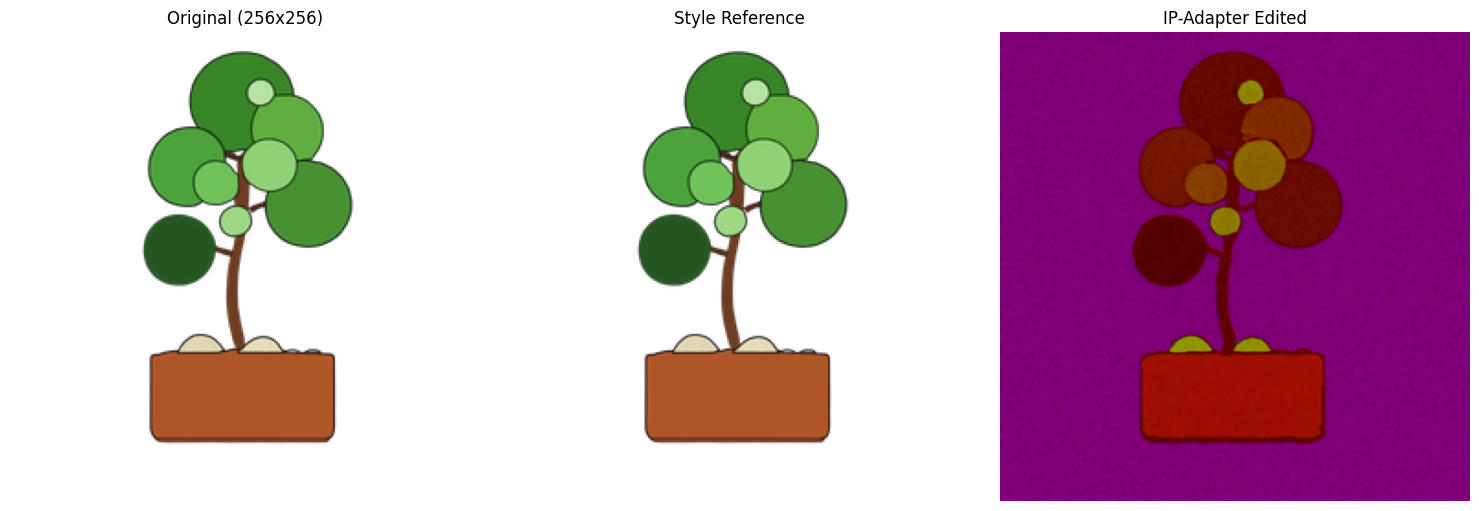

✅ 图像已保存: /content/drive/MyDrive/SVGEditor/test/testCase/bonsai_ip_adapter_256.png
✅ 任务完成!


In [10]:
# ========================================
# IP-Adapter 图像编辑 - 256分辨率版本
# ========================================

import torch
import gc
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import matplotlib.pyplot as plt
import os

def force_cuda_reset():
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.synchronize()

force_cuda_reset()

print("=== IP-Adapter 图像编辑 (256x256) ===")

# 1. 加载基础模型
print("🔄 Loading SD 1.5 base model...")
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    f"{MODEL_PATH}/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
    low_cpu_mem_usage=True
).to("cuda")

# 2. 加载 IP-Adapter (在启用优化之前)
print("🔄 Loading IP-Adapter...")
pipe.load_ip_adapter(
    f"{MODEL_PATH}/ip-adapter",
    subfolder="models",
    weight_name="ip-adapter_sd15.bin"
)

# 3. 启用内存优化
pipe.enable_vae_slicing()
pipe.enable_model_cpu_offload()

print("✅ 模型加载完成")

# 4. 加载和处理图像
pil_image = Image.open(os.path.join(OUTPUT_PATH, f"{TARGET_NAME}_original.png"))
pil_image_256 = pil_image.resize((256, 256), Image.Resampling.LANCZOS)
style_reference = pil_image_256

print(f"图像尺寸: {pil_image_256.size}")

# 5. IP-Adapter 推理 - 可调参数版本
print("🎨 开始 IP-Adapter 推理...")

result = pipe(
    # # === 文本提示 ===
    # prompt="make the tree's branches thicker and more robust; keep flat colors; anime/cartoon style; no texture; maintain original color palette; preserve white background",
    # negative_prompt="photorealistic, detailed textures, shading, gradients, noise, blur, 3d render, realistic",

    # 新的prompt - 强调保持原有特征
    prompt="add more green leaves to the tree, thicker brown tree trunk, more lush foliage, simple flat colors, vector art style, clean white background, maintain exact same color scheme",

    # 更详细的negative prompt
    negative_prompt="colored background, photorealistic, detailed textures, shading, gradients, shadows, noise, blur, 3d render, realistic, abstract, pattern, complex colors, dark background",


    # === 图像输入 ===
    image=pil_image_256,                    # 原始图像
    ip_adapter_image=style_reference,       # 风格参考图像

    # === 核心可调参数 ===
    strength=0.3,                          # 编辑强度 [关键参数1]
    guidance_scale=7,                     # CFG引导强度 [关键参数2]
    ip_adapter_scale=10,                   # IP-Adapter风格强度 [关键参数3]
    num_inference_steps=45,                 # 推理步数 [关键参数4]

    # === 输出设置 ===
    height=256,
    width=256,
    num_images_per_prompt=1,

    # === 随机种子 (可选) ===
    generator=torch.Generator().manual_seed(42)
).images[0]

print("✅ 推理完成!")

# 6. 显示结果
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(pil_image_256)
axes[0].set_title("Original (256x256)")
axes[0].axis('off')

axes[1].imshow(style_reference)
axes[1].set_title("Style Reference")
axes[1].axis('off')

axes[2].imshow(result)
axes[2].set_title("IP-Adapter Edited")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# 7. 保存结果
edited_filename = f"{TARGET_NAME}_ip_adapter_256.png"
saved_edited_path = os.path.join(OUTPUT_PATH, edited_filename)
result.save(saved_edited_path)

print(f"✅ 图像已保存: {saved_edited_path}")

# 8. 清理内存
del pipe
force_cuda_reset()
print("✅ 任务完成!")